In [22]:
%pip install transformer_lens
%pip install git+https://github.com/callummcdougall/eindex.git
%pip install sae-vis
%pip install matplotlib
%pip install numpy scikit-learn umap-learn matplotlib


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/callummcdougall/eindex.git to /tmp/pip-req-build-uhkfx7kb
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/eindex.git /tmp/pip-req-build-uhkfx7kb
  Resolved https://github.com/callummcdougall/eindex.git to commit 307eecdd77b2ded7d2db41d7880e2a1a65272c1c
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 9.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Standard imports
import torch
from datasets import load_dataset
import os
import sys
from transformer_lens import utils, HookedTransformer
from datasets.arrow_dataset import Dataset
from huggingface_hub import hf_hub_download
import time
from transformer_lens import HookedTransformer

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading
PORT = 8000

# Library imports
from sae_vis.model_fns import AutoEncoder, AutoEncoderConfig
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig

torch.set_grad_enabled(False);

In [4]:
from sae_group import SAEGroup

pretrained_path = 'trained_autoencoders_final/sae_group_gpt_openweb_bloom_init_features.pt'

# Load the pretrained SAEGroup
pretrained_sae_group = SAEGroup.load_from_pretrained(pretrained_path)


encoder = pretrained_sae_group.autoencoders[0]


In [5]:
from IPython.display import IFrame, display, HTML
import os

def display_vis_inline(filename: str, height: int = 850):
    '''
    Displays the HTML files in a Jupyter Notebook.
    '''
    # Check if the file exists
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"No file found at specified path: {filename}")

    # Display the HTML file in an iframe
    display(IFrame(filename, width='100%', height=height))


In [6]:
for k, v in encoder.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (768, 24576)
b_enc: (24576,)
W_mid: (24576, 24576)
b_mid: (24576,)
W_dec: (24576, 768)
b_dec: (768,)


In [7]:
model = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model gpt2 into HookedTransformer


In [8]:
SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("NeelNanda/c4-code-20k", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (119790 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (108364 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (106716 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (113281 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (121222 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

torch.Size([325017, 128])


In [9]:
# Specify the hook point you're using, the features you're analyzing, and the batch size for gathering activations
sae_vis_config = SaeVisConfig(
    hook_point = 'blocks.0.hook_resid_post',
    features = range(100),
    batch_size = 2000,
    verbose = True,
)

# Gather the feature data
sae_vis_data = SaeVisData.create(
    encoder = encoder,
    model = model,
    tokens = all_tokens, # type: ignore
    cfg = sae_vis_config,
)

# Save as HTML file & display vis
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename, feature_idx=8)

display_vis_inline(filename)

Forward passes to cache data for vis:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/100 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 6.20s  │ 27.3% │
│ (3) Computing feature acts from model acts     │ 0.21s  │ 0.9%  │
│ (4) Getting data for tables                    │ 0.11s  │ 0.5%  │
│ (5) Getting data for histograms                │ 0.10s  │ 0.4%  │
│ (6) Getting data for sequences                 │ 15.95s │ 70.2% │
│ (7) Getting data for quantiles                 │ 0.16s  │ 0.7%  │
└────────────────────────────────────────────────┴────────┴───────┘

In [11]:
for name, param in encoder.named_parameters():
    print(f"Layer Name: {name}")
    print(f"Parameter Shape: {param.size()}")
    print(f"Values: \n{param}\n")

Layer Name: W_enc
Parameter Shape: torch.Size([768, 24576])
Values: 
Parameter containing:
tensor([[-0.0051,  0.0068, -0.0824,  ..., -0.0199, -0.0023, -0.0029],
        [ 0.0234, -0.0057,  0.0462,  ...,  0.0245,  0.0148, -0.0056],
        [-0.0140,  0.0227,  0.0179,  ..., -0.0013,  0.0047,  0.0093],
        ...,
        [ 0.0208,  0.0019,  0.0077,  ...,  0.0342,  0.0064,  0.0240],
        [ 0.0413,  0.0140, -0.0145,  ...,  0.0505,  0.0112,  0.0471],
        [-0.0365, -0.0143,  0.0453,  ..., -0.0390, -0.0205, -0.0078]],
       device='cuda:0', requires_grad=True)

Layer Name: b_enc
Parameter Shape: torch.Size([24576])
Values: 
Parameter containing:
tensor([-0.2882, -0.0174, -0.3979,  ..., -0.0287, -0.0193, -0.0469],
       device='cuda:0', requires_grad=True)

Layer Name: W_mid
Parameter Shape: torch.Size([24576, 24576])
Values: 
Parameter containing:
tensor([[ 2.5715e-02, -5.2542e-05,  9.5891e-03,  ..., -1.3988e-02,
         -1.4744e-02, -1.4625e-02],
        [-1.3369e-02,  1.0868e-02,

In [59]:
layer_transformation = encoder.W_mid.detach().to('cpu')
decoder_matrix= encoder.W_dec.detach().to('cpu')

print(decoder_matrix.shape)

torch.Size([24576, 768])


In [15]:
L = layer_transformation
L.shape

torch.Size([24576, 24576])

In [60]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt


import numpy as np



def transform_feature(feature_in):
    # Encoding
    encoded_feature = np.dot(feature_in, encoder.W_enc.detach().cpu().numpy()) + encoder.b_enc.detach().cpu().numpy()
    
    # Apply non-linearity (ReLU)
    coefficients = np.maximum(encoded_feature, 0)  # Using np.maximum for ReLU
    
    # Middle layer transformation without non-linearity
    mid_layer_output = np.dot(coefficients, encoder.W_mid.detach().cpu().numpy()) + encoder.b_mid.detach().cpu().numpy()
    
    # Decoding
    feature_out = np.dot(mid_layer_output, encoder.W_dec.detach().cpu().numpy()) + encoder.b_dec.detach().cpu().numpy()
    
    return feature_out

selected_indices = np.random.choice(decoder_matrix.shape[0], 200, replace=False)
features = decoder_matrix[selected_indices]



# Step 2: Transform each row using the transform_feature function
transformed_features = []
for feature in features:
    transformed_feature = transform_feature(feature)
    transformed_features.append(transformed_feature)

# Step 3: Create UMAP visualizations for original and transformed features
reducer = umap.UMAP()

# Original features visualization
original_embedding = reducer.fit_transform(features)

# Transformed features visualization
transformed_embedding = reducer.fit_transform(transformed_features)

# Plot the visualizations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_embedding[:, 0], original_embedding[:, 1], c=np.arange(len(features)), cmap='Spectral', s=5)
plt.title('UMAP Visualization of Original Features')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(transformed_embedding[:, 0], transformed_embedding[:, 1], c=np.arange(len(transformed_features)), cmap='Spectral', s=5)
plt.title('UMAP Visualization of Transformed Features')
plt.colorbar()

plt.show()

KeyboardInterrupt: 

torch.Size([24576, 768])
torch.Size([200, 768])


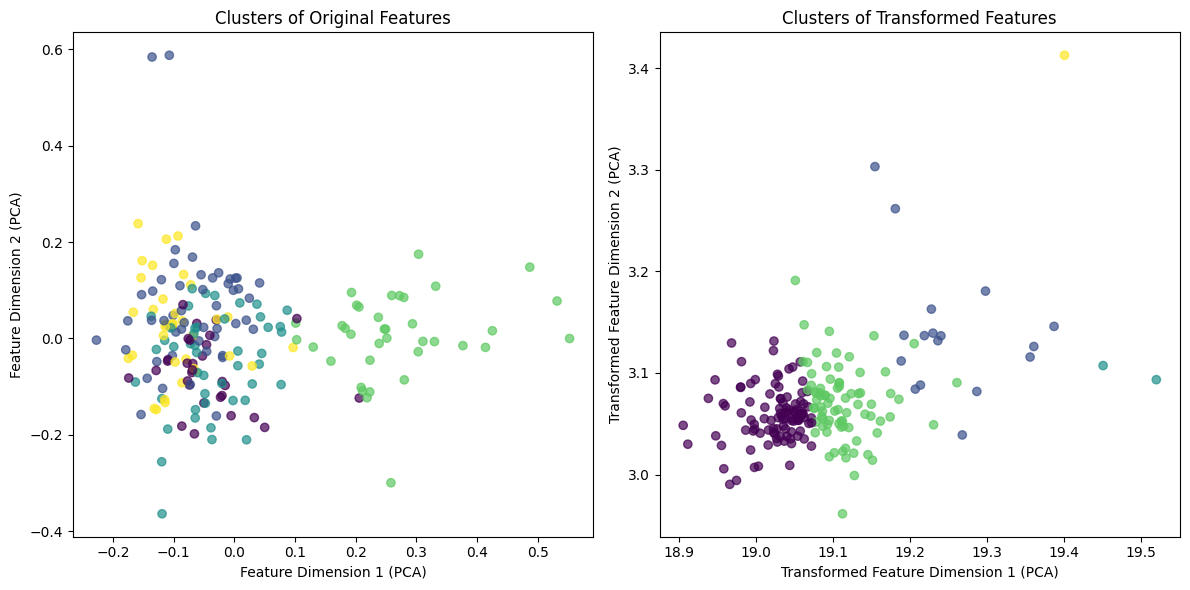

In [61]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming `features` is your high-dimensional data
# Assuming `transform_feature` is your transformation function
print(decoder_matrix.shape)
selected_indices = np.random.choice(decoder_matrix.shape[0], 200, replace=False)
features = decoder_matrix[selected_indices]

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Reducing to 100 dimensions
reduced_features = pca.fit_transform(features)
print(features.shape)

# Step 2: Cluster the original features
n_clusters = 5  # Define the number of clusters
kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_orig = kmeans_orig.fit_predict(reduced_features)

# Step 3: Apply the transform-feature function to the features
transformed_features = []
for feature in features:
    transformed_feature = transform_feature(feature)
    transformed_features.append(transformed_feature)
transformed_features = np.array(transformed_features)

# Step 4: Apply PCA to transformed features
reduced_transformed_features = pca.transform(transformed_features)

# Step 5: Cluster the transformed features
kmeans_transformed = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_transformed = kmeans_transformed.fit_predict(reduced_transformed_features)

# Step 6: Visualize both sets of clusters
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot clusters of original features
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels_orig, cmap='viridis', alpha=0.7)
axs[0].set_title('Clusters of Original Features')
axs[0].set_xlabel('Feature Dimension 1 (PCA)')
axs[0].set_ylabel('Feature Dimension 2 (PCA)')

# Plot clusters of transformed features
axs[1].scatter(reduced_transformed_features[:, 0], reduced_transformed_features[:, 1], c=cluster_labels_transformed, cmap='viridis', alpha=0.7)
axs[1].set_title('Clusters of Transformed Features')
axs[1].set_xlabel('Transformed Feature Dimension 1 (PCA)')
axs[1].set_ylabel('Transformed Feature Dimension 2 (PCA)')

plt.tight_layout()
plt.show()



